# ChiPy/ACM 2017 ICA demonstrations
## Jupyter notebook available at http://chipy2017.pacsites.org

1. Blind source separation demo (the cocktail party problem) - Jorge Yanar
2. ICA used in artifact removal (e.g., line noise or eye blinks from EEG) - Pavan Ramkumar
3. How it works - an "intuitive", geometric demo of ICA - Mark V. Albert
4. What ICA can tell us about how the brain processes sensory information - Anne Zhao

*(thanks to Jason Moss and Ashley Purdy from Metis https://www.thisismetis.com for covering
food and drink for this event)*

In [1]:
# packages used among multiple sections

import sklearn.decomposition # For FastICA and PCA
from IPython.display import Image, Audio

# setting up interactive plotting
import pylab as py
# to show plots directly in the notebook
%matplotlib inline

import numpy as np
# just changes precision for printing, easier on the eyes
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True) # to supress exponential notation

# Blind Source Separation

It's often important to isolate what is important to us from background noise.
This is especially the case in voice recognition where we want to isolate the
speaker from the surrounding noise to improve recognition accuracy

let's step through an example...

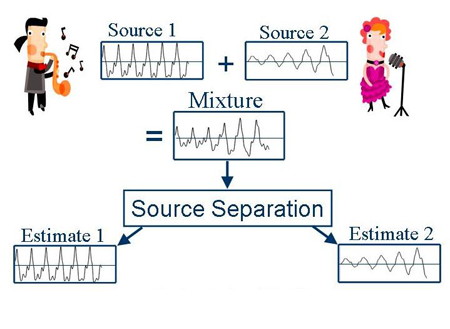

In [2]:
Image(filename="slides/bss_intro.jpg",width="80%")
# pic from the Interactive Audio Lab at Northwestern with Jinyu Han, Zafar Rafii, Bryan Pardo

In [3]:
# the original music
Audio("data/bss_sounds/bach.wav")

In [4]:
# the original speaker
Audio("data/bss_sounds/speech.wav")

## the toy problem: simulating mixing of sounds by multiple microphones in a room

In [5]:
# time to mix the sounds and create the wav

# import to be able to work with wave files
import scipy.io.wavfile as wave

# read in the wave files - results should be int16 type
(rate, bach_data) = wave.read('data/bss_sounds/bach.wav')
(rate, speech_data) = wave.read('data/bss_sounds/speech.wav')

# make mix1 at a 1:1 ratio
mix1 = 0.5 * speech_data + 0.5 * bach_data
wave.write('results/mix1.wav',rate, np.asarray(mix1,dtype=np.int16))

# make mix 2 at a 3:1 ratio, speech to bach
mix2 =  1 * speech_data + 0.333 * bach_data
wave.write('results/mix2.wav',rate, np.asarray(mix2,dtype=np.int16))

In [6]:
# the first microphone
# (mixed at a ratio of 1:1)
Audio("results/mix1.wav")

In [7]:
# the second microphone
# (mixed at a ratio of 3:1 speech to bach
Audio("results/mix2.wav")

### Note, all the remaining code does not know anything about the original sounds
### or how they were mixed!

In [8]:
# read the mixed sounds
(rate, mix1) = wave.read('results/mix1.wav')
(rate, mix2) = wave.read('results/mix2.wav')

# put into 2D array/matrix form with dimensions: samples x 2
mixed_X = np.transpose(np.stack((mix1,mix2)))

In [9]:
# now to unmix! Look, it only takes 2 lines.
ica = sklearn.decomposition.FastICA(n_components=2)
unmixed_X = ica.fit_transform(mixed_X)  # Reconstruct unmixed signals

In [10]:
# did it work? let's recreate the sounds
wave.write('results/unmix1.wav',rate, np.asarray(unmixed_X[:,0] / np.max(unmixed_X[:,0]) * 14000,
    dtype=np.int16) )
wave.write('results/unmix2.wav',rate, np.asarray(unmixed_X[:,1] / np.max(unmixed_X[:,1]) * 14000,
    dtype=np.int16) )

In [11]:
Audio("results/unmix1.wav") # can be either speech or bach

In [12]:
Audio("results/unmix2.wav") # can be either speech or bach

### If you are interested in a more in-depth, mathematical analysis of the unmixing:

In [13]:
# sounds good, but how good was it, really?
# not trivial to evaluate since ICA only deals with ratios, not amplitudes

print('formally, this assumes x = A s in matrix notation')
print('s is the separated sources (unmixed_X in the code),')
print('A is the "mixing matrix",')
print('x is the mixed signals, (mixed_X in the code)')

calc_A = ica.mixing_  # Get estimated mixing matrix
print('\nunnormalized mixing matrix:\n',calc_A)
# note, ICA can't determine the amplitude of the original mixes, just ratios
# also, unmix1 may be bach or speech, no preference for which is first

print('\nthis means:')

# renormalize the mixing matrix to be compared with mixing ratios
normed_A = np.zeros((2,2))
print('the ratio of sources (unmix1:unmix2) in mix 1 is:',
      (calc_A[0,1] / calc_A[1,1]) / (calc_A[0,0] / calc_A[1,0]),': 1')
print('the ratio of sources (unmix1:unmix2) in mix 2 is:',
      (calc_A[0,0] / calc_A[0,1]) / (calc_A[1,1] / calc_A[1,0]),': 1')

formally, this assumes x = A s in matrix notation
s is the separated sources (unmixed_X in the code),
A is the "mixing matrix",
x is the mixed signals, (mixed_X in the code)

unnormalized mixing matrix:
 [[ 379483.975 -672397.095]
 [ 758212.203 -451158.023]]

this means:
the ratio of sources (unmix1:unmix2) in mix 1 is: 2.97779277665 : 1
the ratio of sources (unmix1:unmix2) in mix 2 is: 0.94848332044 : 1


# ICA noise removal

ICA is also use to remove "artifacts" from signals
This is common in EEG, where you're trying to pick of electric signals from the brain in the scalp, but stray signals (like the 60 Hz from power lines, or electical signals from eye blinks) may mix into a signal.

Here is a quick demo showing how the same algorithm as above can be used to remove unwanted artifacts.

In this particular example, we are interested in a signal that is made up of a sum of sinusoids, but unfortunately a sawtooth wave was "accidentally" mixed in the signal.

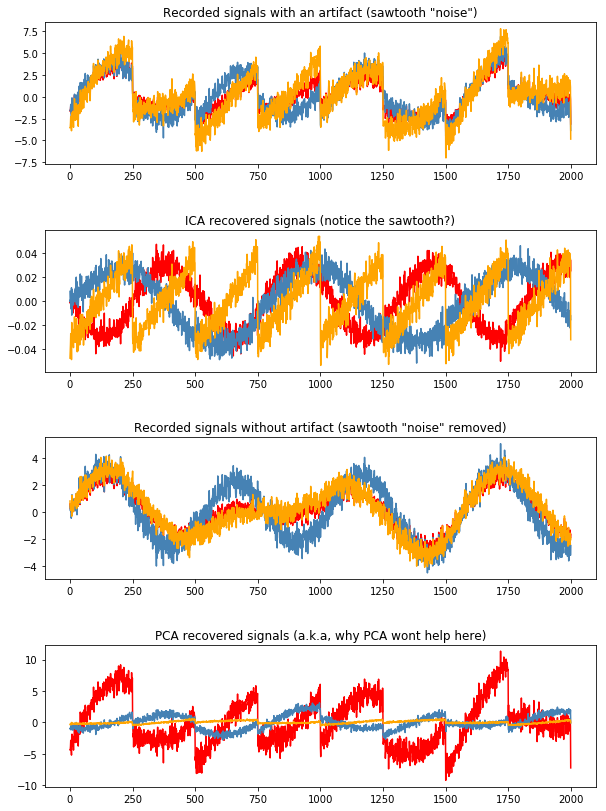

In [14]:
# example adapted from the sklearn blind source separation example
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py

import scipy.signal

np.random.seed(10)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sin(3 * time)  # Signal 2 : square signal
s3 = scipy.signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = sklearn.decomposition.FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# ------------------------------------------
# the part that removes one of the independent components - in this case sawtooth noise
# ------------------------------------------
# remixing after removing one of the components (can't tell ahead which, have to observe)
S_clean = S_.copy()
S_clean[:,2] = 0     # assuming that is the number of the sawtooth component
X_clean = ica.inverse_transform(S_clean)

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = sklearn.decomposition.PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

#Plot results

py.figure(figsize=(9,15))

models = [X, S_, X_clean, H]
names = ['Recorded signals with an artifact (sawtooth "noise")',
         'ICA recovered signals (notice the sawtooth?)',
         'Recorded signals without artifact (sawtooth "noise" removed)',
         'PCA recovered signals (a.k.a, why PCA won''t help here)']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    py.subplot(5, 1, ii)
    py.title(name)
    for sig, color in zip(model.T, colors):
        py.plot(sig, color=color)

py.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)

# ICA theory

## how did that work? remember this...

## the central limit theorem: 
“Given certain conditions, the mean (or equivalently, sum) of a sufficiently large number of independent random variables will be approximately normally distributed, regardless of the underlying distribution”

It's one reason why heights, weights, IQ, etc tend to be normally distribution. 
They are combinations of a large number of independent variables.

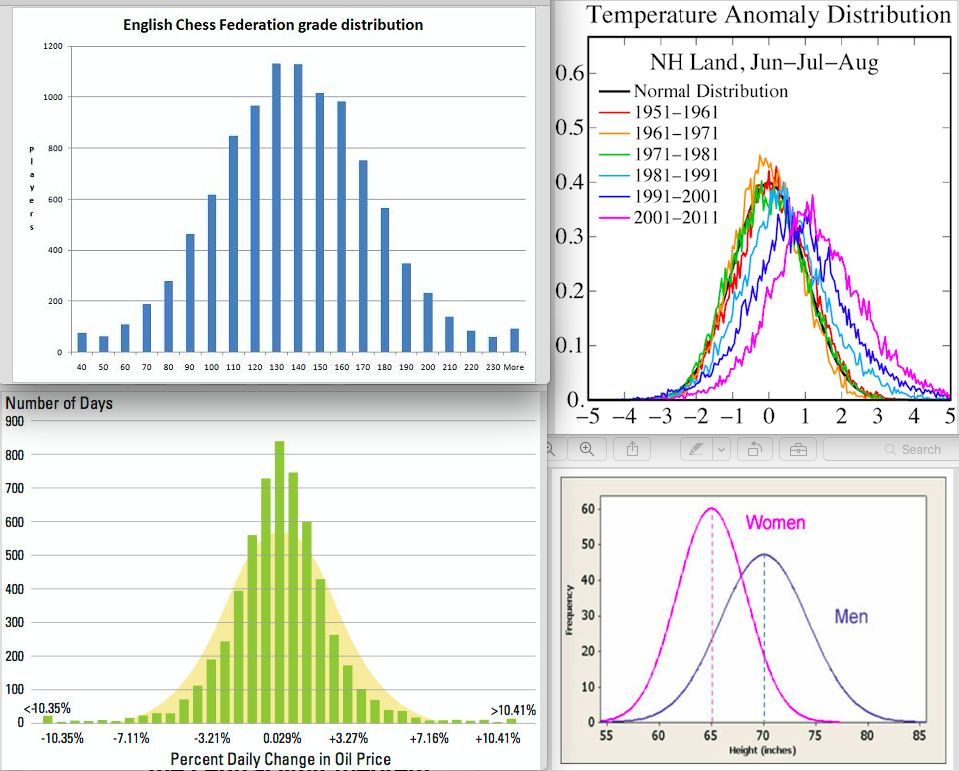

In [15]:
Image(filename="slides/gaussian_distributions.png",width="90%")

So, roughly, mixing MORE independent variables will tend to make the sum MORE gaussian.

ICA, roughly: if we know nothing else and we're looking for original sources or independent mixtures, a good approach to unmixing would be to find the LEAST gaussian combinations.

## Let's see this with an easy-to-visualize example...
(we're doing 2D here, but that's only because it's hard to draw 64D, etc...)

First six samples before noise added:
 [[ 0.     0.    -5.504  5.211 -8.233  0.   ]
 [-9.585  4.976  0.     0.     0.     9.068]]

First six samples after noise added:
 [[ 0.151 -0.146 -5.261  5.412 -8.219  0.235]
 [-9.811  4.794 -0.052  0.163 -0.269  9.28 ]]


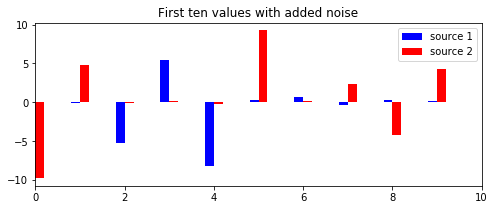

In [16]:
# unknown to the algorithm, we'll start with two original signals, mixed in the same data set
# in this case, X_orig is 0 in one component and a nongaussian distribution in the other

# (this is similar to the FastICA example given in the sklearn documentation)
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py)

n = 200
np.random.seed(10) # to get repeatable runs

X_orig = np.zeros((2,n))
for i in range(0,n):
    if np.random.random() < 0.5: # half the time
        X_orig[0,i] = np.random.uniform(-10,10) # note, important this is NOT gaussian
    else:
        X_orig[1,i] = np.random.uniform(-10,10) # doesn't have to be the same distribution

print('First six samples before noise added:\n', X_orig[:,0:6])
showme = 10
        
# adding input noise
X_orig += np.random.normal(0,0.2,size =(2,n))

print('\nFirst six samples after noise added:\n', X_orig[:,0:6])

# now to plot
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, X_orig[0,0:showme], width=0.2, 
    color='b', label='source 1')
py.bar(np.arange(0,showme) + 0.1, X_orig[1,0:showme], width=0.2, 
    color='r', label='source 2')
py.xlim((0,10))
py.legend()
py.title('First ten values with added noise')

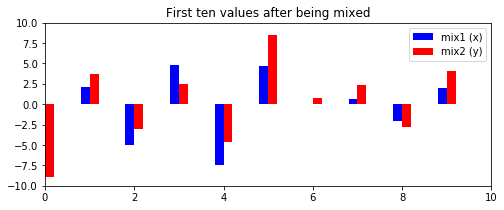

In [17]:
# but the world will mix them without telling us which is which!

# shhhhh we'll mix them at ratios depending on an angle (helpful to visualize later)
angle1 = 30
angle2 = 60
np.random.seed(9) # to get repeatable runs
xmix = np.cos(np.deg2rad(angle1)) * X_orig[0,:] + \
    np.cos(np.deg2rad(angle2)) * X_orig[1,:] + np.random.normal(0,0.4,size =(n)) # adding mixing noise
ymix = np.sin(np.deg2rad(angle1)) * X_orig[0,:] + \
    np.sin(np.deg2rad(angle2)) * X_orig[1,:] + np.random.normal(0,0.4,size =(n))
mixed_X = np.transpose(np.stack((xmix, ymix)))

# plotting the first few samples from the mixtures
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, xmix[0:showme], width=0.2, 
    color='b', label='mix1 (x)')
py.bar(np.arange(0,showme) + 0.1, ymix[0:showme], width=0.2, 
    color='r', label='mix2 (y)')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('First ten values after being mixed')

## From here on, in our toy example, we don't know how they were originally mixed, but we want to get the original separate signals

For a geometric understanding, let's find another way to look at the mixed data. 

Each sample is a point in space where 'x' is the first mixture and 'y' is the second mixture. 

(note, only viewable in 2 or 3 dimensions, but most problems have many more dimensions!)

(-12, 12)

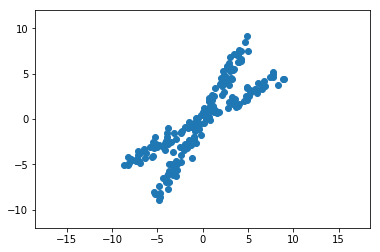

In [18]:
py.scatter(xmix, ymix)
py.axis('equal')
py.xlim((-12,12))
py.ylim((-12,12))

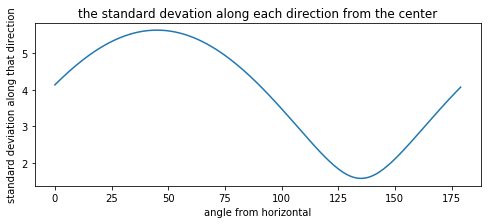

In [19]:
# sweep through directions looking for the directions of maximum variance

angles = np.arange(0,180,1)
std = np.zeros(angles.shape)

proj = np.zeros(xmix.shape)
for (a_i, angle) in enumerate(angles):
    for i in range(xmix.shape[0]):
        proj[i] = xmix[i] * np.cos(np.deg2rad(angle)) + \
            ymix[i] * np.sin(np.deg2rad(angle))
    std[a_i] = np.std(proj)

py.figure(figsize=(8,3))
py.plot(angles, std)
py.title('the standard devation along each direction from the center')
py.xlabel('angle from horizontal')
py.ylabel('standard deviation along that direction')

percent of signal explained by each component: [ 0.928  0.072]


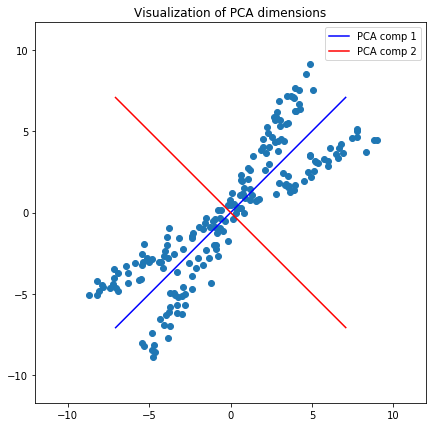

In [20]:
# Aha! let's do a common factor analysis, PCA! (and see why it doesn't give us what we want)

pca = sklearn.decomposition.PCA(n_components=2)
pcafit = pca.fit(mixed_X)

print('percent of signal explained by each component:',pcafit.explained_variance_ratio_) 

#print('the PCA component matrix:\n',pcafit.components_)

pc1x = pcafit.components_[0,0]
pc1y = pcafit.components_[0,1]

pc2x = pcafit.components_[1,0]
pc2y = pcafit.components_[1,1]

py.figure(figsize=(7,7))
py.scatter(xmix, ymix)
py.axis('equal')
py.xlim((-12,12))
py.ylim((-12,12))

# plot the PCA axes
scale = 10
py.plot( (-scale*pc1x,scale*pc1x),
    (-scale*pc1y,scale*pc1y), 'b-', label="PCA comp 1")
py.plot( (-scale*pc2x,scale*pc2x),
    (-scale*pc2y,scale*pc2y), 'r-', label="PCA comp 2")
py.legend()
py.title('Visualization of PCA dimensions')

In [21]:
# transform the signal along these PCA directions - note, just one line of code!
pca_transformed = pcafit.transform(mixed_X)

The original data before mixing:
[[ 0.151 -0.146 -5.261  5.412 -8.219  0.235  0.616]
 [-9.811  4.794 -0.052  0.163 -0.269  9.28   0.105]]
The data transformed along the PCA components:
[[-9.618  4.211 -5.644  5.246 -8.46   9.41   0.619]
 [ 3.004 -0.986 -1.328  1.68  -1.881 -2.641 -0.482]]

Note, the relative magnitudes are right along the first PCA component,
but the second dimension isnt very useful/straightforward to distinguishing the source


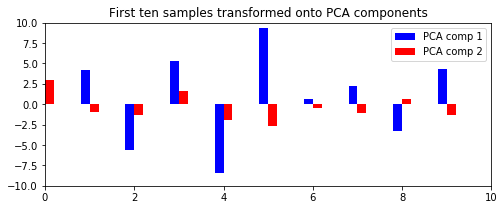

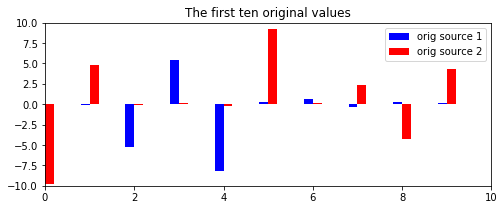

In [22]:
# all of this cell is just to visualize the results

# normalize for comparison to the original
pca_transformed /= np.max(pca_transformed)
pca_transformed *= 10 # since the original was from -10 to 10

print('The original data before mixing:')
print(X_orig[:,0:7])
print('The data transformed along the PCA components:')
print(np.transpose(pca_transformed[0:7,:]))

print('\nNote, the relative magnitudes are right along the first PCA component,')
print('but the second dimension isn''t very useful/straightforward to distinguishing the source')

# plot the PCA components
showme = 10
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, pca_transformed[0:showme,0], width=0.2, 
    color='b', label='PCA comp 1')
py.bar(np.arange(0,showme) + 0.1, pca_transformed[0:showme,1], width=0.2, 
    color='r', label='PCA comp 2')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('First ten samples transformed onto PCA components')

# plot the original
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, X_orig[0,0:showme], width=0.2, 
    color='b', label='orig source 1')
py.bar(np.arange(0,showme) + 0.1, X_orig[1,0:showme], width=0.2, 
    color='r', label='orig source 2')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('The first ten original values')

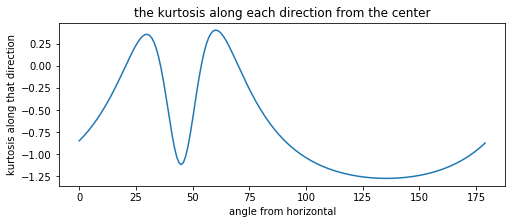

In [23]:
# sweep through directions looking for the "least gaussian"
# in this case we mean kurtosis farthest from 0

import scipy.stats

angles = np.arange(0,180,1)
kurtosis = np.zeros(angles.shape)

proj = np.zeros(xmix.shape)
for (a_i, angle) in enumerate(angles):
    for i in range(xmix.shape[0]):
        proj[i] = xmix[i] * np.cos(np.deg2rad(angle+90)) + \
            ymix[i] * np.sin(np.deg2rad(angle+90))  
            # technically looking at perpendicular projection with the +90
    kurtosis[a_i] = scipy.stats.kurtosis(proj)

py.figure(figsize=(8,3))
py.plot(angles, kurtosis)
py.title('the kurtosis along each direction from the center')
py.xlabel('angle from horizontal')
py.ylabel('kurtosis along that direction')

In [24]:
# Let's use ICA to calculate those directions automatically
ica = sklearn.decomposition.FastICA(n_components=2, max_iter=5000, random_state=8)
# random state is the random seed. Remove for different results each time
icafit = ica.fit(mixed_X)

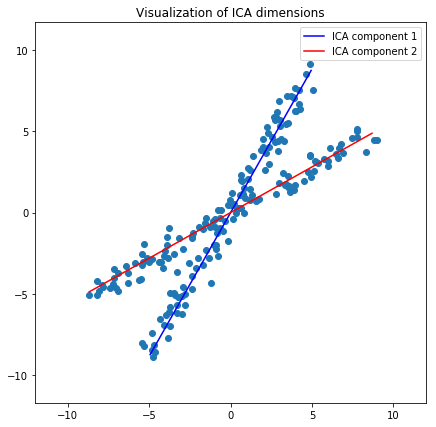

In [25]:
# all the rest of this cell is visualizing those components

comp_mat = icafit.components_   # dimensions: components x features
# print('the (unnormalized "unmixing") ica component matrix:\n',comp_mat)

# normalize components to unit vectors for display purposes 
comp_mat[0,:] = comp_mat[0,:] / np.linalg.norm(comp_mat[0,:])
comp_mat[1,:] = comp_mat[1,:] / np.linalg.norm(comp_mat[1,:])
# print('normalized component matrix:\n',comp_mat)

# the indepenedent components (note, ICA insensitive to scale and permutation)
# 
ic1x = comp_mat[0,0]
ic1y = -comp_mat[1,0]

ic2x = comp_mat[0,1]
ic2y = -comp_mat[1,1]

py.figure(figsize=(7,7))
py.scatter(xmix, ymix)
py.axis('equal')
py.xlim((-12,12))
py.ylim((-12,12))

# plot the ICA axes
scale = 10
py.plot( (-scale*ic1x,scale*ic1x),
    (-scale*ic1y,scale*ic1y), 'b-', label='ICA component 1')
py.plot( (-scale*ic2x,scale*ic2x),
    (-scale*ic2y,scale*ic2y), 'r-', label='ICA component 2')
py.legend()
py.title('Visualization of ICA dimensions')

In [26]:
# let's tranform the signal along those new dimensions - note, just one line of code
ica_transformed = icafit.transform(mixed_X)

The original data before mixing:
[[ 0.151 -0.146 -5.261  5.412 -8.219  0.235  0.616]
 [-9.811  4.794 -0.052  0.163 -0.269  9.28   0.105]]

The data transformed along the ICA components:
[[ 10.     -3.796   0.396   0.421   0.787  -9.255  -1.155]
 [ -0.493  -0.365   5.171  -5.594   7.559  -0.045   0.542]]

Note, the sources are separated and the magnitudes are right (apart from possibly sign)


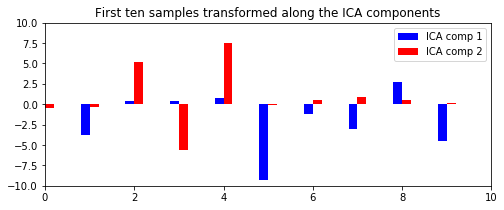

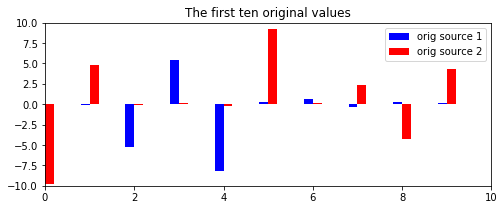

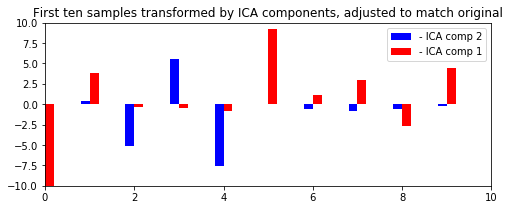

In [27]:
# all of this cell is just to visualize the results

# normalize for comparison to the original
ica_transformed /= np.max(ica_transformed)
ica_transformed *= 10 # since the original was from -10 to 10

show_me = 7
print('The original data before mixing:')
print(X_orig[:,0:show_me])
print('\nThe data transformed along the ICA components:')
print(np.transpose(ica_transformed[0:show_me,:]))

print('\nNote, the sources are separated and the magnitudes are right (apart from possibly sign)')

# plot the ICA components
showme = 10
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, ica_transformed[0:showme,0], width=0.2, 
    color='b', label='ICA comp 1')
py.bar(np.arange(0,showme) + 0.1, ica_transformed[0:showme,1], width=0.2, 
    color='r', label='ICA comp 2')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('First ten samples transformed along the ICA components')

# plot the original
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, X_orig[0,0:showme], width=0.2, 
    color='b', label='orig source 1')
py.bar(np.arange(0,showme) + 0.1, X_orig[1,0:showme], width=0.2, 
    color='r', label='orig source 2')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('The first ten original values')

# plot the ICA components reflected and permuted to match the original
py.figure(figsize=(8,3))
py.bar(np.arange(0,showme) - 0.1, -ica_transformed[0:showme,1], width=0.2, 
    color='b', label='- ICA comp 2')
py.bar(np.arange(0,showme) + 0.1, -ica_transformed[0:showme,0], width=0.2, 
    color='r', label='- ICA comp 1')
py.xlim((0,10))
py.ylim((-10,10))
py.legend()
py.title('First ten samples transformed by ICA components, adjusted to match original')

# ICA in natural images
## why do primary visual cortex neurons behave like they do?

In primary visual cortex (aka V1, the yellow part in the image coming up), neurons respond to particular patterns of light and dark in images. Interestingly, these patterns are reasonably well described by a particular mathematical construct - a 2D Gabor funciton.  

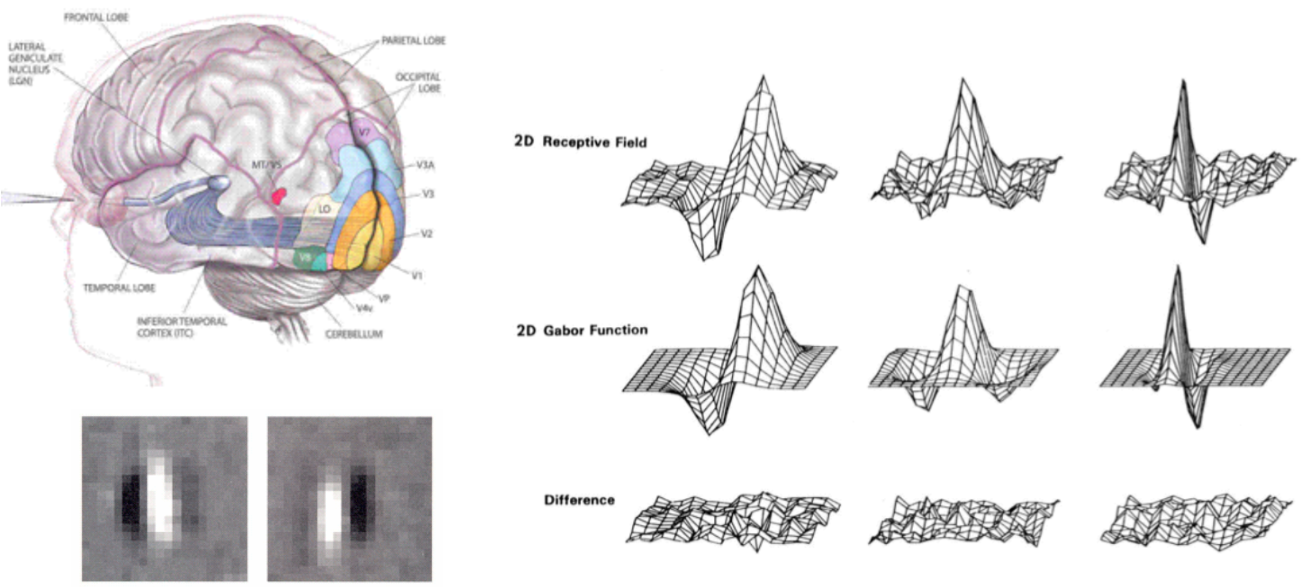

In [28]:
# that "idealization" of a receptive field is not far from the truth

# image on the right from:
# Jones JP, Palmer LA. An evaluation of the two-dimensional Gabor filter model
# of simple receptive fields in cat striate cortex. J Neurophysiol. 1987
# Dec;58(6):1233-58.

Image(filename="slides/v1_receptive_field_intro.png",width="100%")

## what does this have to do with ICA?

We will see that we can understand the neural code, as measured in the brain,
as an efficient coding of our natural world.

But it is important to be clear what we mean by "efficient" (e.g. PCA vs ICA)...

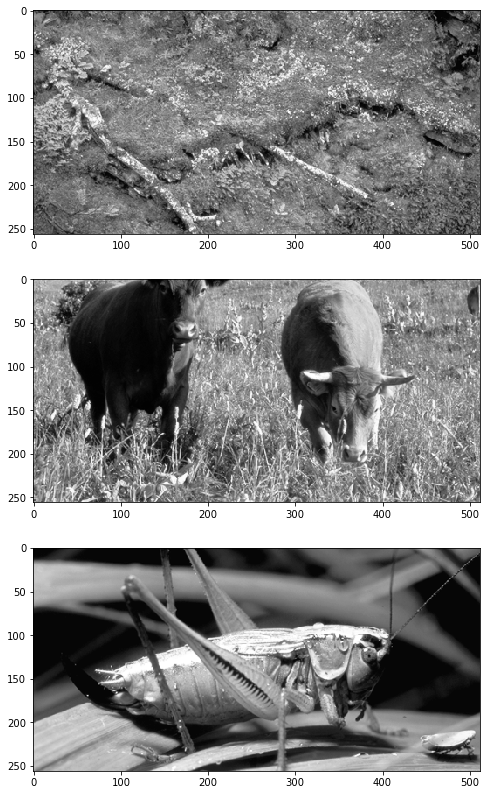

In [29]:
# first let's see some of our natural images we are collecting from

import matplotlib.image as mpimg
import PIL.Image

show_these = ['1.tiff','5.tiff','11.tiff'] # there are 1-13.tiff's

# read in images and display from array form - fix: could be simpler
fig = py.figure(figsize=(8,14))
for (i,file) in enumerate(show_these):
    py.subplot(3,1,i+1)
    img = PIL.Image.open('data/natural_images/'+file)
    py.imshow(img, cmap=py.cm.Greys_r)

In [30]:
# time to collect some small random patches from those images

def collect_natural_patches(num_patches = 100000, patch_width = 8):
  """ collects image patches
  the natural images are from a specific folder of 13 .tiff files"""

  max_tries = num_patches * 50
  image_width = 200
  
  img_first_patch = 0 # the first patch number accepted from an image
  img_first_try = 0 # the first attempt to take a patch from the image
  patch_cnt = 0 # number of collected patches
  try_cnt = 0 # number of attempted collected patches
  num_pixels = patch_width * patch_width

  patch_sample = np.zeros([patch_width,patch_width],float)
  patch = np.zeros([num_pixels,1],float)
  
  img_patches = np.zeros([num_pixels,num_patches],float)

  # change the image sampled from
  nat_img_cnt = 1  
  image = PIL.Image.open('data/natural_images/' + str(nat_img_cnt) + '.tiff')
  image = np.asarray(image, 'double').transpose()  
  # normalizing the image
  image -= image.mean()
  image /= image.std()
      
  # collect the patches
  while patch_cnt < num_patches and try_cnt < max_tries:
    try_cnt += 1  # number of total patches attempted

    if (try_cnt - img_first_try) > max_tries/12 or \
      (patch_cnt - img_first_patch) > num_patches/12:
      # change the image sampled from
      nat_img_cnt += 1
      image = PIL.Image.open('data/natural_images/' + str(nat_img_cnt) + '.tiff')
      image = np.asarray(image, 'double').transpose()        
      # normalizing the image
      image -= image.mean()
      image /= image.std()
      
      img_first_patch = patch_cnt
      img_first_try = try_cnt
    
      # update on every switch of images
      print (int(100 * float(patch_cnt)/num_patches),' percent complete')
    
    px = np.random.randint(0,image_width - patch_width)
    py = np.random.randint(0,image_width - patch_width)
        
    patch_sample = image[px:px+patch_width,py:py+patch_width].copy()
    patch_std = patch_sample.std()
    
    if patch_std > 0.0: # > 0 to remove blank/uninteresting patches for speed
      # create the patch vector     
      patch = np.reshape(patch_sample, num_pixels)     
      patch = patch - np.mean(patch)         
      img_patches[:,patch_cnt] = patch.copy()
      patch_cnt += 1
  return img_patches
        
patches_mat = collect_natural_patches(num_patches = 100000, patch_width = 8)
print('\nshape of the extracted image patch data:', patches_mat.shape)


8  percent complete
16  percent complete
25  percent complete
33  percent complete
41  percent complete
50  percent complete
58  percent complete
66  percent complete
75  percent complete
83  percent complete
91  percent complete

shape of the extracted image patch data: (64, 100000)


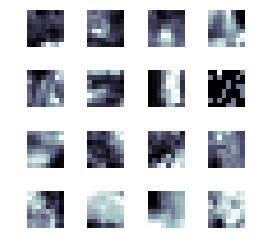

In [31]:
# let's look at some of those patches

def show_patches_mat(pre_patches, show_patch_num = 16, display=True):
  """ this function generates a 2D array to display image patches (assuming square) """
  
  patches = pre_patches
    
  tot_patches = patches.shape[1]
  data_dim = patches.shape[0]
  patch_width = int(np.round(np.sqrt(data_dim)))
  
  # extract show_patch_num patches
  disp_patch = np.zeros([data_dim, show_patch_num], float)
  for i in range(0,show_patch_num):
    patch_i = i * tot_patches // show_patch_num
  
    patch = patches[:,patch_i].copy()
    pmax  = patch.max()
    pmin = patch.min()
    # fix patch range from min to max to 0 to 1
    if pmax > pmin: 
      patch = (patch - pmin) / (pmax - pmin)
    disp_patch[:,i] = patch.copy()

  bw = 5    # border width
  pw = patch_width
  
  patches_y = int(np.sqrt(show_patch_num))
  patches_x = int(np.ceil(float(show_patch_num) / patches_y))
  patch_img = disp_patch.max() * np.ones([(pw + bw) * patches_x - bw,
    patches_y * (pw + bw) - bw], float)
  for i in range(0,show_patch_num): 
    y_i = i // patches_y
    x_i = i % patches_y

    reshaped = disp_patch[:,i].reshape((pw,pw))
    full_patch = np.zeros([pw, pw], float)
    full_patch[0:pw,:] = reshaped[:,:].copy()
    patch_img[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = full_patch
  
  if display:
    py.bone()
    py.imshow(patch_img.T, interpolation='nearest')
    py.axis('off')
  return

show_patches_mat(patches_mat)

## receptive fields, if PCA compression was the kind of "efficient" we wanted...

PCA would be a good choice if we wanted to minimize the number of neurons in the brain

PCA (aka factor analysis) is good for finding a low-dimensional description. Good for compressing the number of bits needed in a representation (or in this case neurons needed to encode a patch) 

Quality of image representation using only 40% as much data per patch 
(using only responses along these 25 components instead of the full 64 dimensions): 
 90.7596593079 %

Percentage of data explained by each filter:
 [ 19.945  17.116   7.642   6.409   5.869   3.834   3.363   3.186   2.687
   2.414   2.024   1.894   1.766   1.597   1.403   1.391   1.187   1.118
   1.088   0.941   0.894   0.87    0.745   0.701   0.677]


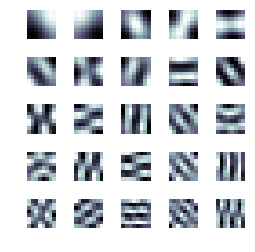

In [32]:
# finding PCA components

pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(np.transpose(patches_mat))

print('Quality of image representation using only 40% as much data per patch',
      '\n(using only responses along these 25 components instead of the full 64 dimensions):',
      '\n',np.sum(100*pcafit.explained_variance_ratio_),'%')

print('\nPercentage of data explained by each filter:\n',100*pcafit.explained_variance_ratio_)

pca_comp = pcafit.components_
show_patches_mat(np.transpose(pca_comp), 25)

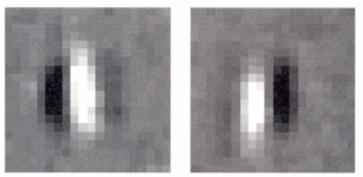

In [33]:
# but remember what receptive field filters look like from real brains

Image(filename="slides/real_receptive_fields.png",width="30%")

## Receptive fields from ICA, closer to "efficient" in the brain

ICA isn't about finding a lower dimensional description. The brain has plenty of neurons. 
The ratio is about 100:1 neurons in V1 compared to axons from the optic nerve
so reducing dimensions likely isn't what we're looking for in a "neurally" efficient code

It may be about finding components which are statistically independent. In other words, each filter response says very little about the likely responses of other filters (note, that's not the case for PCA, where for example, horizontal filters are likely to all fire together with horizontal textures)

(Note, independence is a useful feature for group decision making. Would you rather have 10 independent thinkers deciding, or a room full of "yes people" in group decision making? Same idea here)

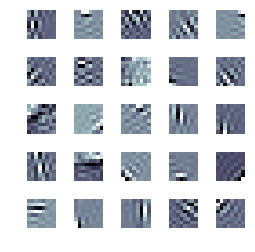

In [34]:
# that's nice, but not what we're looking for.
# how about if we look for components that give us the most independent information
# (note, this is with only 100,000 8x8 patches, so results may not look clean)

# finding ICA components

icatemp = sklearn.decomposition.FastICA(n_components=50) # note, sensitive to n_components
icafit = icatemp.fit(np.transpose(patches_mat))

ica_comp = icafit.components_
# print('shape of the ica component matrix: ',ica_comp.shape)

show_patches_mat(np.transpose(ica_comp), 25)

## ... and the same algorithm also describes the early auditory system

1. Take clips of "natural sounds" (long story about what that means)
2. Efficiently encode them with ICA
3. Display the linear filters describing that code (receptive fields, if they were neurons)
4. Note the similarities between the derived code and experimentally measured receptive fields

The image below is a clip from the following poster

 Makarious M, Moe G, Albert MV.
 Application for interactive demonstration of efficient visual and auditory neural codes
 Society for Neuroscience (SfN 2015)

In [35]:
Image(filename="slides/efficient_coding_poster_clip.png",width="100%")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
